In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline
import geopandas as gpd
import xarray as xr
import matplotlib.dates as mdates

# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, TIModel, BASENAMES, process_era5_daily_data

from oggm.utils import (floatyear_to_date, date_to_floatyear)
# "Downscale" the climate data
from oggm.shop import gcm_climate


In [2]:
cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['store_model_geometry'] = True

# this needs to be changed if working on another computer
working_dir = utils.gettempdir(dirname='W5E5_quality', reset=True)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/no_match'
# My configs
#cfg.PARAMS['hydro_month_nh'] = 1
#climate='W5E5'

2022-11-30 13:31:02: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-11-30 13:31:02: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-11-30 13:31:02: oggm.cfg: Multiprocessing: using all available processors (N=16)
2022-11-30 13:31:02: oggm.cfg: Multiprocessing switched ON after user settings.
2022-11-30 13:31:02: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


In [3]:
# Leh glacier
rgi_id = 'RGI60-14.12678'
gdir = workflow.init_glacier_directories([rgi_id], from_prepro_level=5, prepro_border=80, prepro_base_url=base_url)[0]

2022-11-30 13:31:03: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2022-11-30 13:31:03: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2022-11-30 13:31:03: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/no_match/RGI62/b_080/L5/RGI60-14/RGI60-14.12.tar verified successfully.


In [4]:
# Run the historical period with a fixed geometry spinup
file_id = '_hist_hydro'
tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data,
                     fixed_geometry_spinup_yr=1990,  # this tells to do spinup
                     ref_area_from_y0=True,  # 
                     store_monthly_hydro=True,
                     output_filesuffix=file_id);

2022-11-30 13:31:03: oggm.core.flowline: (RGI60-14.12678) run_with_hydro_hist_hydro
2022-11-30 13:31:03: oggm.core.flowline: (RGI60-14.12678) run_from_climate_data_hist_hydro
2022-11-30 13:31:03: oggm.core.flowline: (RGI60-14.12678) flowline_model_run_hist_hydro


In [5]:
# Read the data
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    ds = ds.isel(time=slice(0, -1)).load()
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    df_annual = ds[sel_vars].to_dataframe()

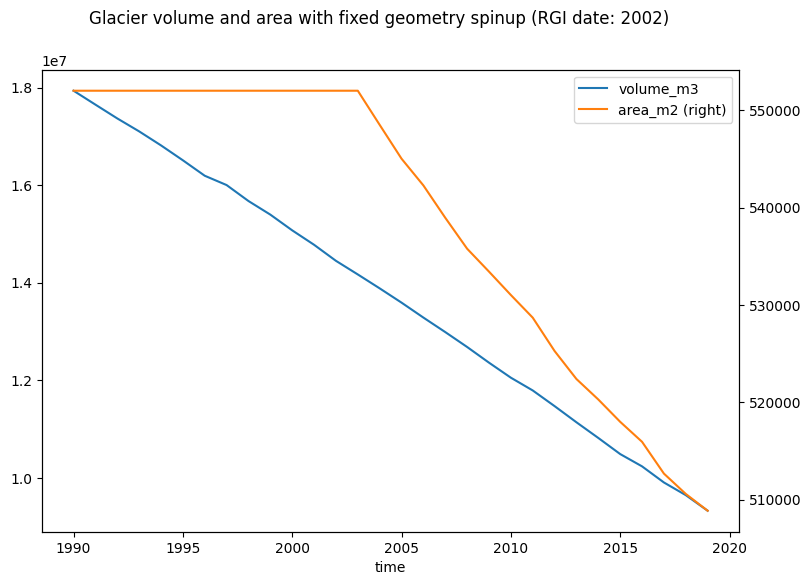

In [6]:
f, ax = plt.subplots(figsize=(9, 6))
df_annual[['volume_m3', 'area_m2']].plot(ax=ax, secondary_y='area_m2');
plt.suptitle(f'Glacier volume and area with fixed geometry spinup (RGI date: {gdir.rgi_date})');

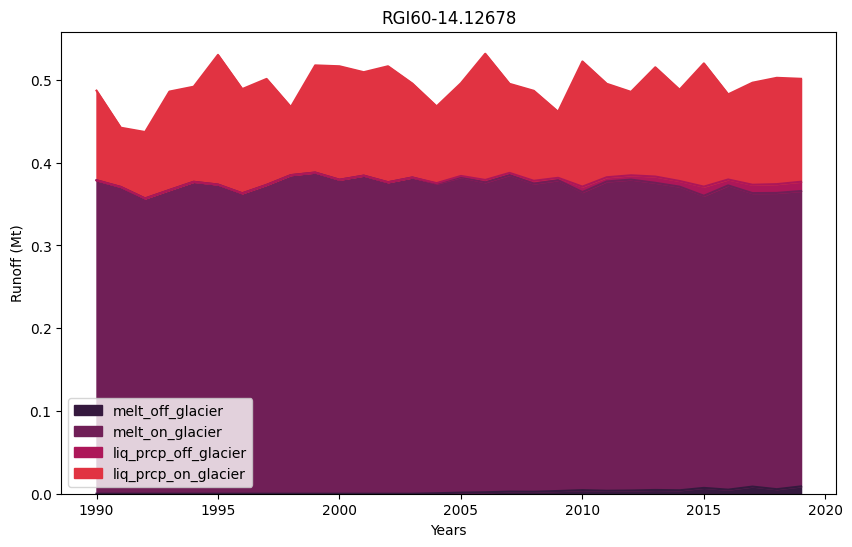

In [8]:
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
f, ax = plt.subplots(figsize=(10, 6));
(df_annual[runoff_vars] * 1e-9).plot.area(ax=ax, color=sns.color_palette("rocket")); 
plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(rgi_id);

In [9]:

bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    # Download the files
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_cmip_data, [gdir],
                                 filesuffix='_CCSM4_{}'.format(rcp),  # recognize the climate file for later
                                 fpath_temp=ft,  # temperature projections
                                 fpath_precip=fp,  # precip projections
                                 );

2022-11-30 13:32:57: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_rcp26_r1i1p1_g025.nc verified successfully.
2022-11-30 13:32:57: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_rcp26_r1i1p1_g025.nc verified successfully.
2022-11-30 13:32:57: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2022-11-30 13:32:57: oggm.shop.gcm_climate: (RGI60-14.12678) process_cmip_data_CCSM4_rcp26
2022-11-30 13:32:57: oggm.shop.gcm_climate: (RGI60-14.12678) process_gcm_data_CCSM4_rcp26
2022-11-30 13:32:58: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_rcp45_r1i1p1_g025.nc verified successfully.
2022-11-30 13:32:58: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_rcp45_r1i1p1_g025.nc verified successfully.
2022-11-30 13:32

In [10]:
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = '_CCSM4_{}'.format(rcp)
    tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data,
                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                         climate_input_filesuffix=rid,  # use the chosen scenario
                         init_model_filesuffix='_hist_hydro',  # this is important! Start from 2020 glacier
                         ref_geometry_filesuffix='_hist_hydro',  # also use this as area reference
                         ref_area_from_y0=True,  # and keep the same reference area as for the historical simulations
                         output_filesuffix=rid,  # recognize the run for later
                         store_monthly_hydro=True,  # add monthly diagnostics
                         );

2022-11-30 13:33:00: oggm.core.flowline: (RGI60-14.12678) run_with_hydro_CCSM4_rcp26
2022-11-30 13:33:00: oggm.core.flowline: (RGI60-14.12678) run_from_climate_data_CCSM4_rcp26
2022-11-30 13:33:00: oggm.core.flowline: (RGI60-14.12678) flowline_model_run_CCSM4_rcp26
2022-11-30 13:33:00: oggm.core.flowline: (RGI60-14.12678) run_with_hydro_CCSM4_rcp45
2022-11-30 13:33:00: oggm.core.flowline: (RGI60-14.12678) run_from_climate_data_CCSM4_rcp45
2022-11-30 13:33:00: oggm.core.flowline: (RGI60-14.12678) flowline_model_run_CCSM4_rcp45
2022-11-30 13:33:01: oggm.core.flowline: (RGI60-14.12678) run_with_hydro_CCSM4_rcp60
2022-11-30 13:33:01: oggm.core.flowline: (RGI60-14.12678) run_from_climate_data_CCSM4_rcp60
2022-11-30 13:33:01: oggm.core.flowline: (RGI60-14.12678) flowline_model_run_CCSM4_rcp60
2022-11-30 13:33:01: oggm.core.flowline: (RGI60-14.12678) run_with_hydro_CCSM4_rcp85
2022-11-30 13:33:01: oggm.core.flowline: (RGI60-14.12678) run_from_climate_data_CCSM4_rcp85
2022-11-30 13:33:01: oggm

In [11]:
file_id = '_CCSM4_rcp26'

In [12]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

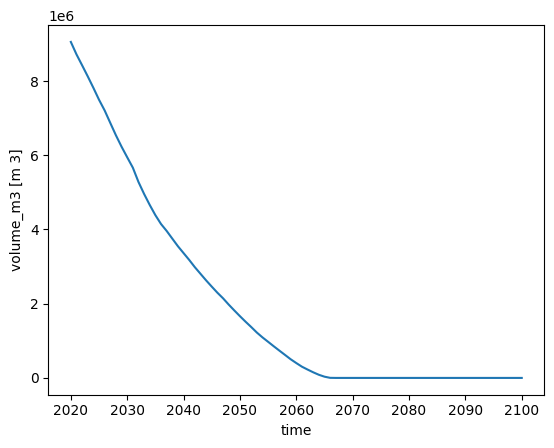

In [13]:
ds.volume_m3.plot();

In [14]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()

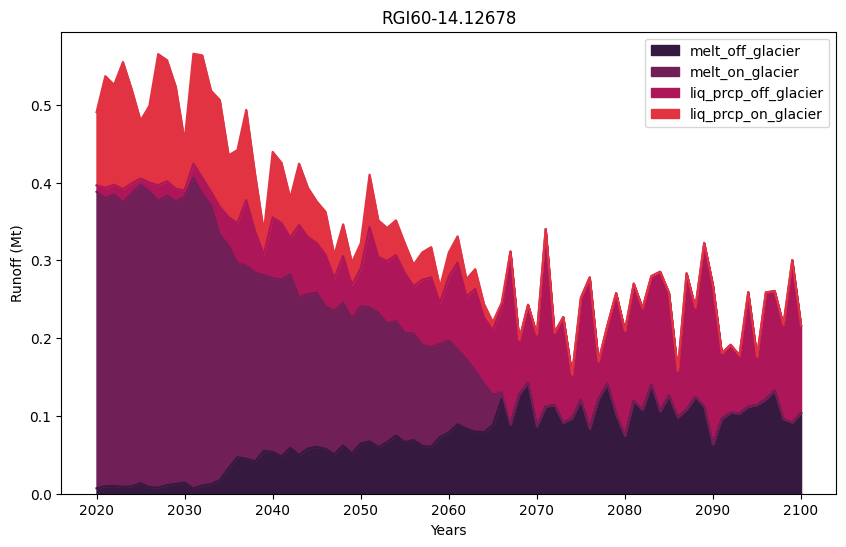

In [15]:
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars].clip(0) * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(rgi_id);
plt.savefig(
        "../figs/Leh_runoff.png",
        bbox_inches="tight",
        dpi=300,
)